Copyright (c) 2017/2018, Johannes Schöneberg All rights reserved.
The default copyright laws apply.

In [9]:
# by Joh Schöneberg 2018

%matplotlib inline

#pip install lvm_read
import lvm_read
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

import scipy.ndimage




%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook

#own modules / functions
import sys
pythonPackagePath = "/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis/"
sys.path.append(pythonPackagePath+"/modules")
import InputProcessing as inproc
import ForceFileProcessing as ffp


In [10]:
path = '/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v12/'

inputParameters = pd.read_csv(path+'_info.csv',names=['key','value'])

inputDataFolder = inproc.getInputParameter(inputParameters,"input_data_folder")


inputParameters[0:5]

,key,value
0,input_data_folder,./
1,output_data_folder,./
2,vesicleID_of_that_day,v12
3,date,2018-07-13
4,movie_originalFilename,v12b2.nd2


In [11]:
def ma(a, n=1000) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:]/n

In [12]:
def getTrajectoryIndexOfTimePoint(timepoint,t):
    return np.where(np.round(t)==timepoint)[0][0]


In [13]:
# this function puts zeros in all positions after the scission event
def cleanForceFileAfterBreak(forceTrajectory,t,breakTime):
    newTrace = []
    idx = getTrajectoryIndexOfTimePoint(breakTime,t)
    for i in range(0,len(forceTrajectory)):
        if(i>=idx):
            newTrace.append(0)
        else:
            newTrace.append(forceTrajectory[i])
    return np.array(newTrace)

/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v12/measurement__235.lvm


Text(0,0.5,'force [AU]')

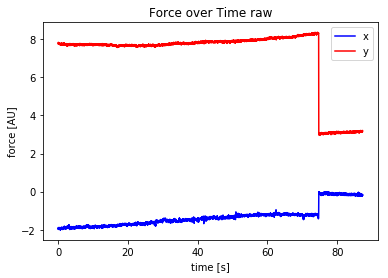

In [14]:
forceFile_raw_dataShareFilename = inproc.getInputParameter(inputParameters,"forceFile_raw_dataShareFilename")
infilename = path+forceFile_raw_dataShareFilename

#infilename = '/Volumes/Samsung_T3b/science/confleezers/2018-07-12/measurement__223.lvm'

print(infilename)
t,x,y,forceFileTimeCreated,xforceraw,yForceRaw = ffp.readForceFile(infilename)


plt.plot(t,scipy.ndimage.median_filter(x,50),c="b",label='x')
plt.plot(t,scipy.ndimage.median_filter(y,50),c="r",label='y')
plt.legend()
plt.title("Force over Time raw")
plt.xlabel("time [s]")
plt.ylabel("force [AU]")

# force file processing

Text(0.5,0,'time (force file time, UV not 0s yet)')

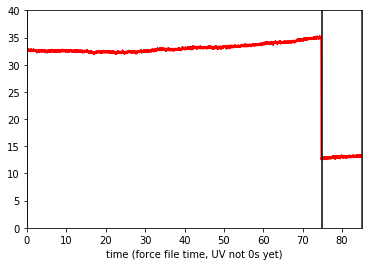

In [22]:
#INTERACTIVE:
# play with the plot ranges until you found the exact break time in seconds
# and the zoom in x that you like

forceFile_alpha_y = float(inproc.getInputParameter(inputParameters,"forceFile_alpha_y"))
forceFile_kappa_y = float(inproc.getInputParameter(inputParameters,"forceFile_kappa_y"))

plt.plot(t,scipy.ndimage.median_filter(forceFile_alpha_y*forceFile_kappa_y*yForceRaw,50),c="r")


plt.xlim(0,85) #use this to search for the exact break time in fftime.
plt.ylim(0,40)

tube_break_seconds_fftime = 75
ffprocessing_zoomTime0 = 0
ffprocessing_zoomTime1 = 85

plt.axvline(tube_break_seconds_fftime,c='k')
plt.axvline(ffprocessing_zoomTime0,c='b')
plt.axvline(ffprocessing_zoomTime1,c='b')
plt.xlabel('time (force file time, UV not 0s yet)')

In [23]:
# put the newly found parameter into the parameter file

row = inputParameters.loc[inputParameters['key'] == 'tube_break_seconds_fftime']
inputParameters.loc[row.index,'value'] = tube_break_seconds_fftime
print(inputParameters.loc[inputParameters['key'] == 'tube_break_seconds_fftime'])
inputParameters.to_csv(path+'_info.csv',index=False,header=False)

row = inputParameters.loc[inputParameters['key'] == 'ffprocessing_zoomTime0']
inputParameters.loc[row.index,'value'] = ffprocessing_zoomTime0
print(inputParameters.loc[inputParameters['key'] == 'ffprocessing_zoomTime0'])
inputParameters.to_csv(path+'_info.csv',index=False,header=False)

row = inputParameters.loc[inputParameters['key'] == 'ffprocessing_zoomTime1']
inputParameters.loc[row.index,'value'] = ffprocessing_zoomTime1
print(inputParameters.loc[inputParameters['key'] == 'ffprocessing_zoomTime1'])
inputParameters.to_csv(path+'_info.csv',index=False,header=False)

# reload the parameter file
inputParameters = pd.read_csv(path+'_info.csv',names=['key','value'])

                          key value
22  tube_break_seconds_fftime    75
40  tube_break_seconds_fftime    75
                       key value
28  ffprocessing_zoomTime0     0
                       key value
29  ffprocessing_zoomTime1    85


In [24]:
#forceScale = 4

forceScale = forceFile_alpha_y*forceFile_kappa_y

UVstart_seconds_fftime = float(inproc.getInputParameter(inputParameters,"UVstart_seconds_fftime"))
tube_break_seconds_fftime = float(inproc.getInputParameter(inputParameters,"tube_break_seconds_fftime"))


time_UV = UVstart_seconds_fftime #seconds after the force file was created
breakTime = tube_break_seconds_fftime #second that the tube breaks
xlimit = (-1.3*time_UV,1.3*(breakTime-time_UV))
print(xlimit)

#this sets the section of the force file that is relevant for future analysis, 
# i.e. from tube pulling to just after break
zoomTime0 = float(inproc.getInputParameter(inputParameters,"ffprocessing_zoomTime0"))
zoomTime1 = float(inproc.getInputParameter(inputParameters,"ffprocessing_zoomTime1"))

(-58.5, 39.0)


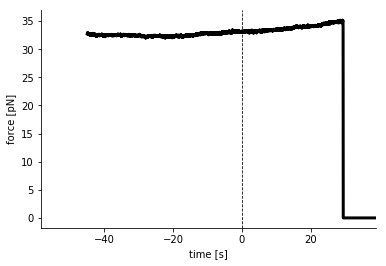

In [25]:
# rescaling the time and cropping the force away after tube breaking

idx0 = getTrajectoryIndexOfTimePoint(zoomTime0,t)
idx1 = getTrajectoryIndexOfTimePoint(zoomTime1,t)



cleanedTrace = scipy.ndimage.median_filter(cleanForceFileAfterBreak(yForceRaw,t,breakTime)[idx0:idx1],100)

plt.plot(t[idx0:idx1]-time_UV,forceScale*cleanedTrace,c='k',lw=3)
plt.xlabel("time [s]")
plt.ylabel("force [pN]")
plt.axvline(0, color='k', linestyle='--', lw=0.8)
plt.xlim(xlimit[0],xlimit[1])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.show()

# if necessary: fit the baseline and adjust the rest accordingly

In [26]:
def plotTraceTime(t,y,idx0=-1,idx1=-1):
    cleanedTrace = scipy.ndimage.median_filter(cleanForceFileAfterBreak(y,t,breakTime)[idx0:idx1],100)

    plt.plot(t[idx0:idx1],forceScale*cleanedTrace,c='k',lw=3)
    plt.xlabel("time [s]")
    plt.ylabel("force [pN]")

#    plt.xlim(time[idxfrom-1000],time[idxto+1000])
    plt.show()

In [27]:
# fit the baseline
# http://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
def fitBaselineLinear(t,y,idx0,idx1):

    time = t
    force = y
    
    
    x = time[idx0:idx1]
    y = force[idx0:idx1]
    
    fit_baseline = np.polyfit(x,y,1)
    fit_fn_baseline = np.poly1d(fit_baseline) 
    # fit_fn is now a function which takes in x and returns an estimate for y
    

    
    def fn(x):
        return np.multiply(fit_fn_baseline[0],x)+fit_fn_baseline[1]
    
    #plt.plot(x,y, '-', x, fit_fn_baseline(x), '--k')
    #plt.show()
    return(fit_baseline)



#plotTraceTime(fileData,idx0,idx1)

In [28]:
def str2bool(v):
    return v.lower() in ("True","yes", "true", "t", "1")

do we do a fit? False
15300 79629


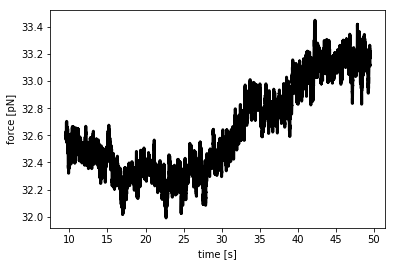

In [29]:
#manually adjust this value
#fit is done from $fitStart to $UV_startTime
# adjust $fitStart according to experimental condition

ffprocessing_doFit = str2bool(inproc.getInputParameter(inputParameters,"ffprocessing_doFit")) #seconds
print('do we do a fit?',ffprocessing_doFit)



if (ffprocessing_doFit):
    
    fitStart = float(inproc.getInputParameter(inputParameters,"ffprocessing_fitStart")) #seconds
    fitEnd = float(inproc.getInputParameter(inputParameters,"ffprocessing_fitEnd"))#UV_startTime

else:
    fitStart = 10
    fitEnd = 50
    
    UV_startTime = time_UV
    
    baseline_idx0 = getTrajectoryIndexOfTimePoint(fitStart,t)
    baseline_idx1 = getTrajectoryIndexOfTimePoint(fitEnd,t)
    print(baseline_idx0,baseline_idx1)
    plotTraceTime(t,yForceRaw,baseline_idx0,baseline_idx1)




Text(0,0.5,'force[pN]')

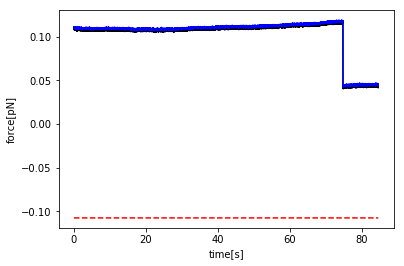

In [30]:




if (ffprocessing_doFit):
    print('do Fitting')
    baselineFit = fitBaselineLinear(t,yForceRaw,baseline_idx0,baseline_idx1)
else:    
    forceNoChange = np.empty(len(t))
    forceNoChange.fill(yForceRaw[baseline_idx1])
    baselineFit = fitBaselineLinear(t,forceNoChange,baseline_idx0,baseline_idx1)




time = t
force = yForceRaw

whole_idx0 = idx0
whole_idx1 = idx1

xx = time[whole_idx0:whole_idx1]
yy = force[whole_idx0:whole_idx1]

fit_fn_baseline = np.poly1d(baselineFit) 
# fit_fn is now a function which takes in x and returns an estimate for y

ws = 20
plt.plot(scipy.ndimage.median_filter(xx,ws),-1*scipy.ndimage.median_filter(yy,ws), '-k', xx, fit_fn_baseline(xx), '--r')
delta= yy[0]-fit_fn_baseline(xx[0])
delta = 0


plt.plot(scipy.ndimage.median_filter(xx,ws),-1*scipy.ndimage.median_filter(yy[0]+yy-fit_fn_baseline(xx)-delta,ws), '-b')
plt.xlabel("time[s]")
plt.ylabel("force[pN]")




/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v12/.//forceFile.png


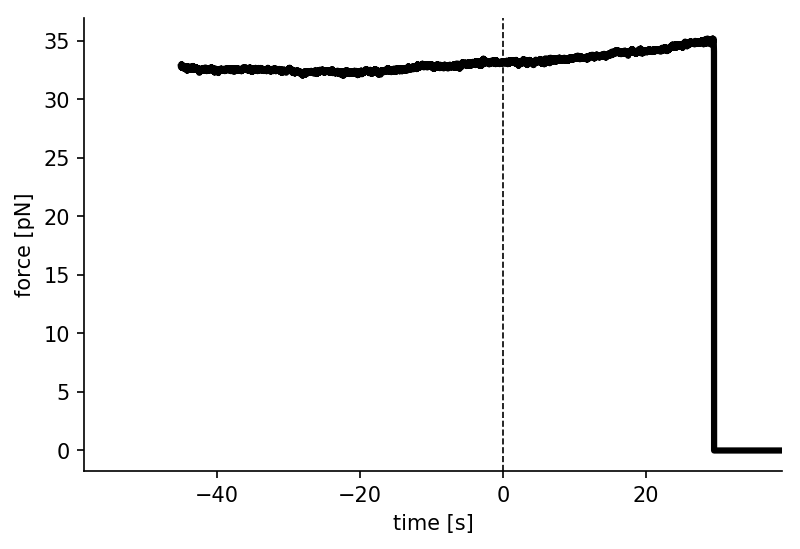

f0_baselineForce: 32.65pN
fmax_maxForce: 35.17pN
∆F: 2.52pN


In [31]:
# rescaling approx..

idx0 = getTrajectoryIndexOfTimePoint(zoomTime0,t)
idx1 = getTrajectoryIndexOfTimePoint(zoomTime1,t)


plt.figure(dpi=150)

setToZeroFirstCoupleRecordings = False

#plt.gca().set_aspect(5)


time = t[idx0:idx1]
#trace = cleanForceFileAfterBreak(y,t,breakTime)[idx0:idx1]
#fittedTrace = fit_fn_baseline(t[idx0:idx1])
if (ffprocessing_doFit):
    trace_correctedFor_drift = yForceRaw-fit_fn_baseline(t)
else:
    trace_correctedFor_drift = yForceRaw
if(setToZeroFirstCoupleRecordings):
    trace_correctedFor_drift_yZero = trace_correctedFor_drift-np.average(trace_correctedFor_drift[0:1000])
else:
    trace_correctedFor_drift_yZero = trace_correctedFor_drift

correctedTrace = forceScale*trace_correctedFor_drift_yZero
timeSlice = t[idx0:idx1]
traceSlice = cleanForceFileAfterBreak(correctedTrace,t,breakTime)[idx0:idx1]
#plt.plot(traceSlice)
#plt.show()
#traceSlice = correctedTrace[idx0:idx1]
#plt.plot(traceSlice)
#plt.show()

#fig = plt.figure(figsize=(6, 4), dpi=100)
plt.plot(timeSlice-time_UV,scipy.ndimage.median_filter(traceSlice,100),c='k',lw=3)
plt.xlabel("time [s]")
plt.ylabel("force [pN]")
plt.axvline(0, color='k', linestyle='--', lw=0.8)

# draw a vertical line where the movie starts if that info is already available
movie_startTime_difference_fftime_seconds = inproc.getInputParameter(inputParameters,"movie_startTime_difference_fftime_seconds")
if(movie_startTime_difference_fftime_seconds != 'TBD'):
    plt.axvline(float(movie_startTime_difference_fftime_seconds)-time_UV, color='blue', linestyle='--', lw=0.8)
    
plt.xlim(xlimit[0],xlimit[1])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.title('black dash: UV, blue dash: movie start')

outputDataFolder = inproc.getInputParameter(inputParameters,"output_data_folder")
forceFile_plot = inproc.getInputParameter(inputParameters,"forceFile_plot")
outputPath = path+outputDataFolder+'/'+forceFile_plot
print()
print(outputPath)
plt.savefig(outputPath)
plt.show()



baselineForce = np.average(correctedTrace[baseline_idx0:baseline_idx1])
traceSliceUvToEnd = traceSlice[getTrajectoryIndexOfTimePoint(time_UV,timeSlice):-1]
maxForce = np.max(scipy.ndimage.median_filter(traceSliceUvToEnd,100))
print("f0_baselineForce: {}pN".format(np.round(baselineForce,2)))
print("fmax_maxForce: {}pN".format(np.round(maxForce,2)))
print("∆F: {}pN".format(np.round(maxForce-baselineForce,2)))





In [32]:
# save in _info.csv
row = inputParameters.loc[inputParameters['key'] == 'force_f0_pN']
inputParameters.loc[row.index,'value'] = np.round(baselineForce,2)
print(inputParameters.loc[inputParameters['key'] == 'force_f0_pN'])

row = inputParameters.loc[inputParameters['key'] == 'force_fmax_pN']
inputParameters.loc[row.index,'value'] = np.round(maxForce,2)
print(inputParameters.loc[inputParameters['key'] == 'force_fmax_pN'])

row = inputParameters.loc[inputParameters['key'] == 'force_deltaF_pN']
inputParameters.loc[row.index,'value'] = np.round(maxForce-baselineForce,2)
print(inputParameters.loc[inputParameters['key'] == 'force_deltaF_pN'])


inputParameters.to_csv(path+'_info.csv',index=False,header=False)

            key  value
33  force_f0_pN  32.65
              key  value
34  force_fmax_pN  35.17
                key value
35  force_deltaF_pN  2.52


In [33]:
## OUTPUT
outputDataFolder = inproc.getInputParameter(inputParameters,"output_data_folder")
forceFile_name = inproc.getInputParameter(inputParameters,"forceFile")
outputPath = path+outputDataFolder+'/'+forceFile_name
print(outputPath)

#only write every 10th datapoint (otherwise you end up with 10s of megabytes of force data)
out_time = (timeSlice-time_UV)[::10]
out_force = scipy.ndimage.median_filter(traceSlice,100)[::10]
output_data = np.transpose(np.asarray((out_time,out_force)))


with open(outputPath,'wb') as outfile:
    np.savetxt(outfile, 
           output_data, 
           delimiter=',',
           fmt='%10.5f',
           header="time[s], force[pN]"
              ) 

/Volumes/Samsung_T3b/science/confleezers/2018-07-13/v12/.//forceFile.csv


# QPD raw readout

In [11]:
 lvm = lvm_read.read(infilename, read_from_pickle=False)
#print(lvm['Description'])

#datetime = getLVMdatetime(lvm[0]['Time'][0],lvm[0]['Date'][0])

data = lvm[0]['data']
t = data[:,0]
xForce = data[:,1]
yForce = data[:,2]
xForceRaw = data[:,3]
yForceRaw = data[:,4]
a_voltage = data[:,5]
b_voltage = data[:,6]
c_voltage = data[:,7]
d_voltage = data[:,8]


plt.plot(t,scipy.ndimage.median_filter(a_voltage,50),c="k",label='a_voltage')
plt.plot(t,scipy.ndimage.median_filter(b_voltage,50),c="y",label='b_voltage')
plt.plot(t,scipy.ndimage.median_filter(c_voltage,50),c="g",label='c_voltage')
plt.plot(t,scipy.ndimage.median_filter(d_voltage,50),c="orange",label='d_voltage')
plt.legend()
plt.title("Raw Voltages QPD")
plt.xlabel("time [s]")
plt.ylabel("Voltage [AU]")

KeyboardInterrupt: 